In [0]:
# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítimo o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

#Solución

Se cargan los datos y se preparan según el ejemplo sugerido por el profesor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
##
## Verifica la lectura de los datos
##
df.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


In [4]:
##
## Se obtiene la cantidad de casos para
## cada tipo de mensaje.
##
df.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

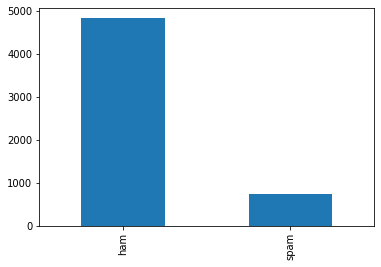

In [5]:
df.type.value_counts().plot.bar();

In [6]:
##
## Se convierte el conteo anterior en probabilidades.
##
round(100 * df.type.value_counts() / sum(df.type.value_counts()), 1)

ham     86.6
spam    13.4
Name: type, dtype: float64

In [7]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


In [8]:
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1540)

In [9]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [10]:
##
## Primeras palabras del vocabulario
##
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

In [11]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

In [0]:
##
## Creación de los conjuntos de entrenamiento y prueba.
##
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.type[0:4168]
y_test_true  = df.type[4169:]

In [13]:

##
## Distribución de los datos en el conjunto de entrenamiento.
##
round(100 * y_train_true.value_counts() / sum(y_train_true.value_counts()), 1)

ham     86.5
spam    13.5
Name: type, dtype: float64

In [14]:
##
## Distribución de los datos en el conjunto de prueba.
##
round(100 * y_test_true.value_counts() / sum(y_test_true.value_counts()), 1)

ham     87.0
spam    13.0
Name: type, dtype: float64

En este punto hay que ver que se ha utilizado una Regresión logistica como modelo para la clasificación

In [15]:
##
## Entrena el modelo
##
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

##
## Se entrena el clasificador
##
clf.fit(X_train.toarray(), y_train_true)
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
##
## Se pronostica para los datos de prueba.
##
y_test_pred = clf.predict(X_test.toarray())
y_test_pred_prob = clf.predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [18]:
##
## Métricas de desempeño
##
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test_true,
                 y_pred = y_test_pred)

array([[1221,    1],
       [  26,  157]])

In [19]:
%%R -i y_test_true -i y_test_pred
##
## Se calcula la matriz de confusión.
##
table(y_test_true, y_test_pred)

           y_test_pred
y_test_true  ham spam
       ham  1221    1
       spam   26  157


In [20]:
%%R
##
## Para el análisis resulta mejor construir la
## matriz de confusión
##
 install.packages("gmodels")
##
library(gmodels)
CrossTable(y_test_pred,
           y_test_true,
           prop.chisq = FALSE,
           prop.t = FALSE,
           dnn = c('predicted', 'actual'))

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘gtools’, ‘gdata’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gtools_3.8.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 197529 bytes (192 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1405 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1221 |        26 |      1247 | 
             |     0.979 |     0.021 |     0.888 | 
             |     0.999 |     0.142 |           | 
-------------|-----------|-----------|-----------|
        spam |         1 |       157 |       158 | 
             |     0.006 |     0.994 |     0.112 | 
             |     0.001 |     0.858 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1222 |       183 |      1405 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


In [21]:
##
## Resulta más conveniente preparar una nueva tabla que
## muestre la clasificación y no únicamente las
## probabilidades.
##
results = pd.DataFrame(data = {
    'actual_type':  y_test_true,
    'predict_type': y_test_pred,
    'prob_ham':     [v[0] for v in y_test_pred_prob],
    'prob_spam':    [v[1] for v in y_test_pred_prob]})

results.head(5)

,actual_type,predict_type,prob_ham,prob_spam
4169,spam,spam,0.019598,0.980402
4170,ham,ham,0.925093,0.074907
4171,ham,ham,0.888100,0.111900
4172,ham,ham,0.999433,0.000567
4173,ham,ham,0.996573,0.003427


En este punto tenemos un modelo base, sus metricas de desempeño y con estos datos, podemos proceder a crear una red neuronal para comparar los resultados.

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
rkf = RepeatedKFold(n_splits=10,
                    random_state=1)
X      = dtm[:,]
Y = df.type


validation_errors = []
training_errors = []

modelos = {}
## i = numero de neuronas en la capa oculta
for i in range(1,11):
    breakingFlag=False
    m = MLPClassifier(activation='relu', 
                      hidden_layer_sizes=(i,), 
                      learning_rate='adaptive',
                      learning_rate_init=0.001, 
                      random_state=1, 
                      shuffle=True,
                      warm_start=True,
                      max_iter=10000)
                      #early_stopping = True) #No es posible porque con warm start true no existe el atributo Best_loss, y sin él, demora mucho más todo el proceso
    modelos[i] = m
    Y_tested = []
    Y_predicted = []
    error_entrenamiento = 0
    error_validacion = 0
    c=0
    for train, test in rkf.split(X):

        ### Entrenar
        X_train = X[train]
        Y_train = Y[train]
        X_test = X[test]
        Y_test = Y[test]
        modelos[i].fit(X_train,Y_train)
        error_entrenamiento+=(m.loss_)
        c+=1
        Y_pred = modelos[i].predict(X_test)
        error_validacion += accuracy_score(Y_test,Y_pred)
    validation_errors.append(error_validacion/c)
    training_errors.append(error_entrenamiento/c)
    #print(error_validacion/c)
print(validation_errors)
print(training_errors)

[0.9986546270020534, 0.9986903405983157, 0.9982778324742774, 0.9988339671692313, 0.998762314755829, 0.9988339671692315, 0.9987801072051383, 0.9993004639550077, 0.998977465042503, 0.9987979961776806]
[0.012148719510551222, 0.00689221483332514, 0.007465367387385794, 0.005777196828438137, 0.005038300767057908, 0.0051002899443434516, 0.005231971814240053, 0.0044988512757704255, 0.004843275948439386, 0.005469273775020527]


Observamos los errores de validación y de entrenamiento en una gráfica para interpretar más fácilmente cuál es la red neuronal que mejores resultados da

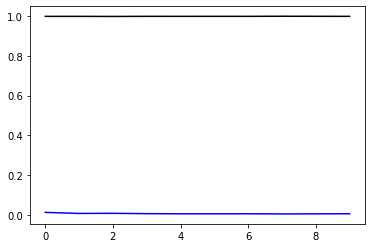

In [25]:
import matplotlib.pyplot as plt

aa = plt.subplot()
b = list(range(len(validation_errors)))
aa.plot(b, validation_errors, color='black');

b = list(range(len(training_errors)))
aa.plot(b, training_errors, color='blue');

plt.show()

Como los resultados son poco claros se separan las gráficas para observar mejor

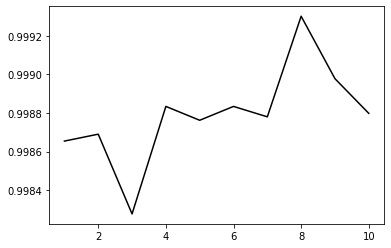

In [30]:
aa = plt.subplot()
b = list(range(1,len(validation_errors)+1))
aa.plot(b, validation_errors, color='black');

plt.show()

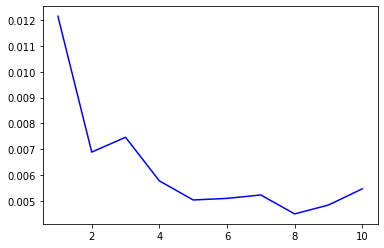

In [32]:
aa = plt.subplot()

b = list(range(1,len(training_errors)+1))
aa.plot(b, training_errors, color='blue');

plt.show()

Se puede observar que con 3 neuronas el error de validación es el mínimo, y el error de entrenamiento es bajo también, sin embargo, hay que tener en cuenta que la escala nos muestra errores de ordenes muy similares, por lo que dependiendo del problema, uno podría pensar que una red neuronal con 1 sola neurona es suficientemente precisa para cumplir con los objetivos propuestos.
En este caso se continuará con la red de 3 neuronas en la capa oculta.

Se vuelven a definir los X y Y como se definieron inicialmente, pues durante el crossvalidation de la red neuronal se redefinieron y se procede a obtener las metricas de desempeño

In [48]:
##
## Se pronostica para los datos de prueba.
##
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.type[0:4168]
y_test_true  = df.type[4169:]


y_test_pred = modelos[1].predict(X_test.toarray())
y_test_pred_prob = modelos[1].predict_proba(X_test.toarray())
y_test_pred

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [49]:
y_test_pred_prob

array([[1.28345311e-06, 9.99998717e-01],
       [9.96756543e-01, 3.24345712e-03],
       [9.96756543e-01, 3.24345712e-03],
       ...,
       [9.96756543e-01, 3.24345712e-03],
       [9.96756543e-01, 3.24345712e-03],
       [9.96756543e-01, 3.24345712e-03]])

In [51]:
##
## Métricas de desempeño
##
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test_true,
                 y_pred = y_test_pred)

array([[1222,    0],
       [   1,  182]])

In [52]:
%%R -i Y_test -i y_test_pred
##
## Se calcula la matriz de confusión.
##
table(y_test_true, y_test_pred)

           y_test_pred
y_test_true  ham spam
       ham  1222    0
       spam    1  182


In [53]:
%%R
##
## Para el análisis resulta mejor construir la
## matriz de confusión
##
# install.packages("gmodels")
##
library(gmodels)
CrossTable(y_test_pred,
           y_test_true,
           prop.chisq = FALSE,
           prop.t = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1405 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1222 |         1 |      1223 | 
             |     0.999 |     0.001 |     0.870 | 
             |     1.000 |     0.005 |           | 
-------------|-----------|-----------|-----------|
        spam |         0 |       182 |       182 | 
             |     0.000 |     1.000 |     0.130 | 
             |     0.000 |     0.995 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1222 |       183 |      1405 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


Se puede ver que los datos son concluyentes, obteniendo en el mismo set de datos un solo error, en contra de los más de 20 errores obtenidos con la regresión logística, por lo que el mejor clasificador según los datos disponibles es la red neuronal con una sola neurona en la capa oculta